### N-gram in General

An **n-gram** is a contiguous sequence of `n` items from a given sample of text or speech. In the context of language modeling and text analysis, the items are typically words or characters. N-grams are used to analyze and predict sequences of words or characters based on their prior occurrences in a dataset.

- **Unigram**: A single word or character (e.g., "hello").
- **Bigram**: A sequence of two words or characters (e.g., "hello world").
- **Trigram**: A sequence of three words or characters (e.g., "hello world again").
- **n-gram**: A general term for any sequence of `n` items.

**N-grams** are employed in various natural language processing (NLP) tasks, such as text prediction, speech recognition, and machine translation. They help in modeling the likelihood of a word or character sequence by leveraging the frequency of observed sequences in the training data.

### N-gram in This Code

In the provided code, the n-gram model is implemented to predict and generate text based on sequences of words. Here's a summary of its role and functionality:

1. **Tokenization and N-gram Creation**:
   - **Tokenization**: The text data (song lyrics) is first tokenized into individual words.
   - **N-gram Generation**: Sequences of `n` words are created, where `n` is set to 3 (trigrams). This helps in capturing the context of word sequences.

2. **Frequency Counting**:
   - **Counting N-grams**: The code counts the frequency of each n-gram (trigram) in the dataset. This helps in understanding the occurrence of different word sequences.

3. **Probability Calculation**:
   - **Probability Estimation**: Based on the frequency counts, probabilities are calculated for each n-gram. Laplace (add-one) smoothing can be applied to handle unseen n-grams by assigning them a small non-zero probability.

4. **Text Scoring and Perplexity**:
   - **Scoring**: The model calculates the probability of a given sentence based on the learned n-gram probabilities, helping in evaluating the likelihood of text sequences.
   - **Perplexity**: The model measures how well it predicts a sample sentence. Lower perplexity indicates better performance and fit of the model to the data.

In essence, the n-gram model in this code helps in understanding and predicting sequences of words in song lyrics, leveraging the frequency of observed trigrams to generate and evaluate text.


***

### N-Gram Model for Ed Sheeran Songs

#### Step 1: Imports


In [44]:
import pandas as pd
import string
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from itertools import islice

### Step 2: Helper Functions


In [45]:
def take(n, iterable):
    """
    Return the first n items of the iterable as a list.

    Parameters:
    - n (int): The number of items to retrieve from the beginning of the iterable.
    - iterable (iterable): An iterable object (e.g., list, tuple, generator) from which to take items.

    Returns:
    - list: A list containing the first n items from the iterable.
    
    Example:
    >>> take(3, [1, 2, 3, 4, 5])
    [1, 2, 3]
    """
    # Import islice from itertools to handle slicing of iterables
    from itertools import islice
    
    # Use islice to create an iterator that returns the first n items from the iterable
    # Convert the iterator to a list and return it
    return list(islice(iterable, n))


### Step 3: Define the Language Model Class


In [38]:
class LanguageModel_NGram:
    UNK = "<UNK>"  # Token for unknown words
    SENT_BEGIN = "<s>"  # Token for the beginning of a sentence
    SENT_END = "</s>"  # Token for the end of a sentence

    def __init__(self, n_gram=3, is_laplace_smoothing=1):
        """
        Initialize the N-gram model with specified parameters.

        :param n_gram: Size of the n-grams (e.g., 3 for trigrams)
        :param is_laplace_smoothing: Use Laplace smoothing if True
        """
        self.n_gram = n_gram  # Set the n-gram size
        self.is_laplace = is_laplace_smoothing  # Set Laplace smoothing flag
        
        # Initialize data structures
        self.data = []  # Raw dataset
        self.lyric_dic = {}  # Dictionary to store lyrics by song title
        self.corpus = []  # List to store all lyrics combined
        self.lyric_dic_updated = {}  # Processed lyrics with special tokens
        self.lyric_dic_processed = {}  # Further processed lyrics for n-gram analysis
        self.token_count_dic = {}  # Token frequency dictionary
        self.ngram_token_count_dict = {}  # N-gram token frequency dictionary
        self.total_tokens = 0  # Total number of tokens in the corpus
        self.total_vocab = 0  # Total number of unique tokens in the corpus
        self.unk_words = []  # List to hold rare words considered as unknown tokens
        
        self.prob_dic = {}  # Dictionary to hold probabilities of n-grams
        self.ngram_tokenized_words = []  # List to store tokenized n-grams
        self.unique_tokens_to_count_previous_dic = {}  # Dictionary for unique token counts
        
    def load_dataset(self, link_to_dataset):
        """
        Load dataset from a CSV file.

        :param link_to_dataset: Path to the dataset file
        """
        self.data = pd.read_csv(link_to_dataset, encoding='utf-8')  # Load the dataset into a DataFrame
        print(self.data.head(20))  # Print the first 20 rows of the dataset for inspection
        
    def dataset_cleaning(self):
        """
        Clean and preprocess the dataset.
        """
        lyric_dic = {}  # Initialize a dictionary to store lyrics by song
        corpus = []  # List to store all lyrics
        
        data = self.data  # Reference the dataset
        prev = data["Song Title"].iloc[0]  # Initialize previous song title
        temp = []  # Temporary list to accumulate lyrics for the same song

        # Group lyrics by song title
        for index, rows in data.iterrows():  # Iterate through each row in the DataFrame
            lyrics = rows["Lyrics"]  # Extract lyrics from the current row
            if pd.isna(lyrics):  # Skip rows with missing lyrics
                continue
            corpus.append(lyrics)  # Add lyrics to the corpus
            if prev == rows["Song Title"]:  # Check if current song title matches previous
                temp.append(lyrics)  # Accumulate lyrics for the same song
            else:
                lyric_dic[prev] = temp  # Save accumulated lyrics for the previous song
                prev = rows["Song Title"]  # Update previous song title
                temp = []  # Reset temporary list
                temp.append(lyrics)  # Start accumulating lyrics for the new song
        lyric_dic[prev] = temp  # Add the last accumulated lyrics

        self.lyric_dic = lyric_dic  # Store the lyrics dictionary
        self.corpus = corpus  # Store the combined lyrics corpus

        # Preprocess lyrics for each song
        lyric_dic_updated = {}  # Dictionary to hold preprocessed lyrics
        for song in lyric_dic:  # Iterate through each song
            t_songs = []  # List to hold processed lyrics for a song
            for lyrics in lyric_dic[song]:  # Process each set of lyrics
                t_words = []  # List to hold processed words
                t_songs.append(self.preprocess_text(lyrics))  # Preprocess and add to list
            lyric_dic_updated[song] = t_songs  # Save processed lyrics

        self.lyric_dic_updated = lyric_dic_updated  # Store the updated lyrics dictionary

        # Tokenize and preprocess lyrics with special tokens
        lyric_dic_processed = {}  # Dictionary to hold further processed lyrics
        for song_name in lyric_dic_updated:  # Iterate through each song
            temp_array = ["<s>"] * (self.n_gram - 1)  # Add start tokens

            for sentence in lyric_dic_updated[song_name]:  # Process each sentence
                temp = sentence.split()  # Split sentence into words
                temp[-1] = temp[-1] + "/n"  # Append new line token to the last word
                temp_array.extend(temp)  # Add words to the array

            temp_array.extend(["</s>"] * (self.n_gram - 1))  # Add end tokens
            lyric_dic_processed[song_name] = temp_array  # Save processed lyrics
        
        self.lyric_dic_processed = lyric_dic_processed  # Store the processed lyrics dictionary
        
    def preprocess_text(self, text):
        """
        Preprocess the text by lowercasing and removing punctuation and stopwords.
        
        :param text: Input text to preprocess
        :return: Preprocessed text
        """
        if isinstance(text, str):  # Ensure the text is a string
            text = text.lower()  # Convert text to lowercase
            text = "".join([i for i in text if i not in string.punctuation])  # Remove punctuation
            text = " ".join([i for i in text.split() if i not in stopwords.words('english')])  # Remove stopwords
        return text
    
    def ngram_tokenization(self, sentences):
        """
        Generate n-grams from the tokenized sentences.

        :param sentences: List of tokenized sentences
        :return: List of n-grams
        """
        tokens = []  # List to hold n-grams
        for sentence in sentences:  # Iterate through each sentence
            sen = sentence.split()  # Split sentence into words
            for t in range(len(sen) - self.n_gram + 1):  # Generate n-grams
                tokens.append(tuple(sen[t:t + self.n_gram]))  # Add n-gram to list
        return tokens
    
    def count_all_token_freq(self, tokenized_words):
        """
        Count frequency of each n-gram token.

        :param tokenized_words: List of tokenized n-grams
        :return: Dictionary of n-gram token frequencies
        """
        d = {}  # Dictionary to hold token frequencies
        for token in tokenized_words:  # Iterate through each token
            temp_tuple = tuple(token)  # Convert token to tuple
            if temp_tuple not in d:  # Check if token is already in dictionary
                d[temp_tuple] = 1  # Initialize frequency count
            else:
                d[temp_tuple] += 1  # Increment frequency count
        return d
    
    def count_unique_tokens(self, sentences_from_file):
        """
        Count frequency of unique n-gram tokens.

        :param sentences_from_file: List of sentences
        :return: Dictionary of unique n-gram token frequencies
        """
        word_d = {}  # Dictionary to hold unique token frequencies
        for sen in sentences_from_file:  # Iterate through each sentence
            sen = sen.split()  # Split sentence into words
            for t in range(len(sen) - self.n_gram + 1):  # Generate n-grams
                if self.n_gram == 1:
                    token = tuple(sen[t:t + self.n_gram])  # Create unigram
                else:
                    token = tuple(sen[t:t + self.n_gram - 1])  # Create n-gram of size n-1
                
                if token not in word_d:  # Check if token is already in dictionary
                    word_d[token] = 1  # Initialize frequency count
                else:
                    word_d[token] += 1  # Increment frequency count
        return word_d

    def dataset_preprocess(self):
        """
        Preprocess the dataset to count tokens and initialize vocabulary.
        """
        token_count_dic = {}  # Dictionary to hold token counts
        count = 0  # Initialize total token count
        for song_name in self.lyric_dic_updated:  # Iterate through each song
            for sentence in self.lyric_dic_updated[song_name]:  # Process each sentence
                for word in sentence.split():  # Split sentence into words
                    if word not in token_count_dic:  # Check if word is already in dictionary
                        token_count_dic[word] = 1  # Initialize frequency count
                    else:
                        token_count_dic[word] += 1  # Increment frequency count
                    count += 1  # Increment total token count
        self.total_tokens = count  # Set total token count
        self.token_count_dic = token_count_dic  # Store token count dictionary

    def display_wordcloud(self):
        """
        Generate and display a word cloud from the corpus.
        """
        text = "".join(self.corpus)  # Combine all lyrics into a single text
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)  # Generate word cloud
        plt.figure(figsize=(10, 5))  # Set figure size for display
        plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud
        plt.axis("off")  # Hide axis
        plt.title("Word Cloud of Song Lyrics")  # Set title
        plt.show()  # Show the plot
        
    def display_stats_before(self):
        """
        Display statistics about the dataset before training.
        """
        print("Dataset Information before preprocessing")
        corpus = self.corpus  # Reference the corpus
        
        num_of_songs = len(self.lyric_dic)  # Get number of songs
        print("Number of songs =", num_of_songs)

        vocab = set()  # Set to hold unique words
        token_size = 0  # Initialize token size count
        word_count = {}  # Dictionary to hold word frequencies
        
        # Calculate vocabulary size and token size
        for sentence in corpus:  # Iterate through each sentence
            tokens = sentence.split()  # Split sentence into words
            vocab.update(tokens)  # Update vocabulary with new words
            token_size += len(tokens)  # Update token size count
            for word in tokens:  # Count word frequencies
                word_count[word] = word_count.get(word, 0) + 1
        
        print("Vocab size =", len(vocab))  # Print vocabulary size
        print("Token size =", token_size)  # Print token size
        
        # Plot word frequency cutoff
        word_count_cutoff = {k: v for k, v in word_count.items() if v > 50}  # Filter words with frequency > 50
        plt.figure(figsize=(12, 8))  # Set figure size for display
        plt.bar(word_count_cutoff.keys(), word_count_cutoff.values())  # Create bar plot
        plt.xticks(rotation=-45)  # Rotate x-axis labels for better visibility
        plt.title('Word Frequency Cutoff')  # Set title
        plt.show()  # Show the plot
        
        # Display a sample song
        n_items = take(1, self.lyric_dic.items())  # Get a sample song
        print(n_items)  # Print the sample song

    def train(self):
        """
        Train the language model using the dataset.
        """
        self.total_unique_tokens = len(self.token_count_dic)  # Set total unique token count
        
        # Identify rare words for unknown token handling
        for token in self.token_count_dic:  # Iterate through each token
            if self.token_count_dic[token] == 1:  # Check if token occurs only once
                self.unk_words.append(token)  # Add to list of unknown words
        
        # Tokenize the processed lyrics
        all_sentences = []  # List to hold tokenized sentences
        for song_name in self.lyric_dic_processed:  # Iterate through each song
            t = " ".join(self.lyric_dic_processed[song_name])  # Combine tokens into a single string
            all_sentences.append(t)  # Add to list of all sentences
        
        self.ngram_tokenized_words = self.ngram_tokenization(all_sentences)  # Generate n-grams
        self.ngram_token_count_dict = self.count_all_token_freq(self.ngram_tokenized_words)  # Count n-gram frequencies
        self.unique_tokens_to_count_previous_dic = self.count_unique_tokens(all_sentences)  # Count unique n-grams
        
        # Calculate probabilities for n-grams
        self.prob_dic = {}  # Dictionary to hold n-gram probabilities
        for token in self.ngram_token_count_dict:  # Iterate through each n-gram
            word = token[:-1]  # Get the prefix of the n-gram
            if self.is_laplace:
                # Calculate probability with Laplace smoothing
                self.prob_dic[token] = (self.ngram_token_count_dict[token] + 1) / (
                            self.unique_tokens_to_count_previous_dic[word] + self.total_unique_tokens)
            else:
                # Calculate probability without smoothing
                self.prob_dic[token] = self.ngram_token_count_dict[token] / self.unique_tokens_to_count_previous_dic[word]
        
        # Debug: Print some probabilities
        print("Sample probabilities:", list(self.prob_dic.items())[:10])  # Print sample probabilities

    def score(self, sentence):
        """
        Calculate the score of a given sentence based on the model probabilities.

        :param sentence: Input sentence to score
        :return: Score of the sentence
        """
        score = 1  # Initialize score
        sen = sentence.split()  # Split sentence into words
        token = ["<s>"] * (self.n_gram - 1)  # Initialize start tokens
        
        for t in range(len(sen)):  # Iterate through each word in the sentence
            token.append(sen[t])  # Add word to token list
            token_temp = tuple(token[t:t + self.n_gram])  # Create n-gram
            if token_temp in self.prob_dic:  # Check if n-gram is in probability dictionary
                score *= self.prob_dic[token_temp]  # Multiply score by n-gram probability
            else:
                score *= 1 / (self.total_unique_tokens + 1)  # Use unknown token probability
        return score  # Return final score
    
    def perplexity(self, sentence):
        """
        Calculate the perplexity of a given sentence.

        :param sentence: Input sentence to calculate perplexity
        :return: Perplexity of the sentence
        """
        sen = sentence.split()  # Split sentence into words
        n = len(sen)  # Get number of words in the sentence
        log_prob_sum = 0  # Initialize sum of log probabilities
        
        token = ["<s>"] * (self.n_gram - 1)  # Initialize start tokens
        for t in range(n):  # Iterate through each word in the sentence
            token.append(sen[t])  # Add word to token list
            token_temp = tuple(token[t:t + self.n_gram])  # Create n-gram
            if token_temp in self.prob_dic:  # Check if n-gram is in probability dictionary
                log_prob_sum += math.log(self.prob_dic[token_temp])  # Add log probability
            else:
                log_prob_sum += math.log(1 / (self.total_unique_tokens + 1))  # Use log of unknown token probability
        
        perplexity = math.exp(-log_prob_sum / n)  # Calculate perplexity
        return perplexity  # Return perplexity


### Step 4: Evaluation and Display

In [46]:
# Example usage
lm = LanguageModel_NGram(n_gram=3, is_laplace_smoothing=1)

# 1. Load dataset
lm.load_dataset('ed_sheeran_cleaned_songs.csv')

# 2. Clean and preprocess dataset
lm.dataset_cleaning()
lm.dataset_preprocess()


                                  Song Title  \
0            \nShe Looks So Perfect Lyrics\n   
1                    \nShape of You Lyrics\n   
2                         \nPerfect Lyrics\n   
3                      \nPhotograph Lyrics\n   
4               \nThinking Out Loud Lyrics\n   
5                         \nHappier Lyrics\n   
6                          \nA Team Lyrics\n   
7                      \nI See Fire Lyrics\n   
8             \nSupermarket Flowers Lyrics\n   
9              \nCastle on the Hill Lyrics\n   
10                   \nGive Me Love Lyrics\n   
11                   \nPerfect Duet Lyrics\n   
12                          \nDon't Lyrics\n   
13               \nAll Of The Stars Lyrics\n   
14               \nPerfect Symphony Lyrics\n   
15                        \nKiss Me Lyrics\n   
16                           \nDive Lyrics\n   
17  \nYou Need Me, I Don't Need You Lyrics\n   
18                     \nLego House Lyrics\n   
19                   \nTenerife Sea Lyri

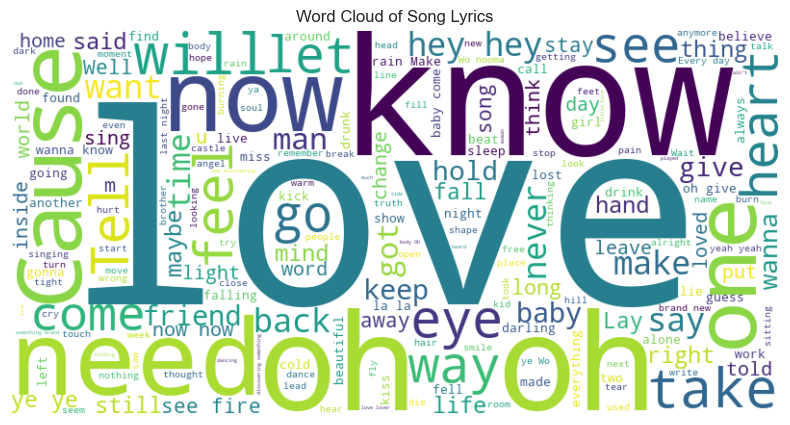

In [47]:
# 3. Display word cloud
lm.display_wordcloud()

Dataset Information before preprocessing
Number of songs = 111
Vocab size = 4632
Token size = 62012


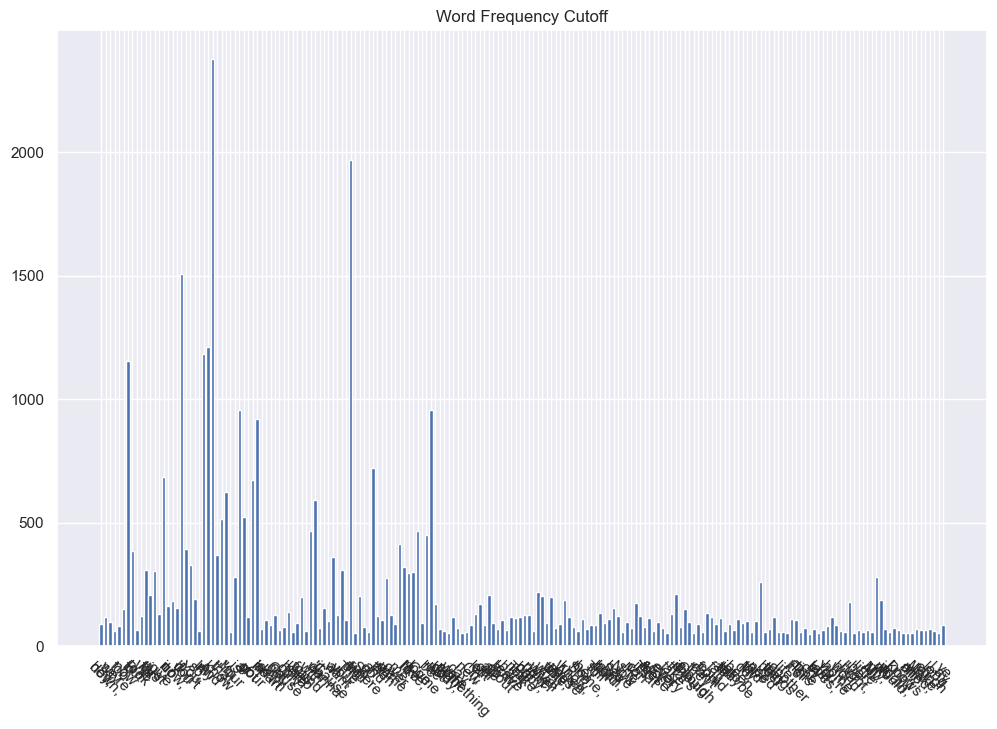

[('\nShe Looks So Perfect Lyrics\n', [" Hey, hey, hey, hey, Hey, hey, hey, hey, Hey, hey, hey, hey Simmer down, simmer down, They say we're too young now to amount to anything else, But look around, We work too damn hard for this just to give it up now, If you don't swim, you'll drown, But don't move, honey, You look so perfect standing there, In my American Apparel underwear, And I know now, that I'm so down, Your lipstick stain is a work of art, I got your name tattooed in an arrow heart And I know now, that I'm so down (whoa) Hey, hey!, Hey, hey, hey, hey Hey, hey, Hey, hey Let's get out, let's get out', Cause this deadbeat town's only here just to keep us down, While I was out, I found myself alone just thinking, If I showed up with a plane ticket, And a shiny diamond ring with your name on it, Would you wanna run away too?, 'Cause all I really want is you, You look so perfect standing there, In my American Apparel underwear, And I know now, that I'm so down Your lipstick stain is 

In [48]:
# 4. Display statistics before training
lm.display_stats_before()

In [49]:
# 5. Train the language model
lm.train()

Sample probabilities: [(('<s>', '<s>', 'hey'), 0.0006565988181221273), (('<s>', 'hey', 'hey'), 0.0006811989100817438), (('hey', 'hey', 'hey'), 0.015420717398592021), (('hey', 'hey', 'simmer'), 0.0006704659738518271), (('hey', 'simmer', 'simmer'), 0.0006811989100817438), (('simmer', 'simmer', 'say'), 0.0006811989100817438), (('simmer', 'say', 'young'), 0.0006811989100817438), (('say', 'young', 'amount'), 0.0006811989100817438), (('young', 'amount', 'anything'), 0.0006811989100817438), (('amount', 'anything', 'else'), 0.0006811989100817438)]


In [50]:
# 6. Load test data and preprocess it
test_data = pd.read_csv("ed_sheeran_cleaned_songs.csv", encoding='windows-1252')
test_data = test_data.dropna(subset=['Lyrics'])
all_sentences = [lm.preprocess_text(row["Lyrics"]) for _, row in test_data.iterrows()]

# 7. Pick random sentences and evaluate them
for i in range(10):
    random_sentence = random.choice(all_sentences)
    print("Random Sentence:", random_sentence)
    
    # Calculate and print score and perplexity
    score = lm.score(random_sentence)
    print("Score:", score)
    
    perplexity = lm.perplexity(random_sentence)
    print("Perplexity:", perplexity)
    print()

Random Sentence: walking 29th park saw anothers arms month weve apart look happier saw walk inside bar said something make laugh saw smiles twice wide yeah look happier aint nobody hurt like hurt aint nobody love like promise take personal baby youre moving someone new cause baby look happier friends told one day ill feel ill smile hide truth know happier sat corner room everythings reminding nursing empty bottle telling youre happier arent aint nobody hurt like hurt aint nobody need like know theres others deserve darling still love guess look happier friends told one day ill feel could try smile hide truth know happier baby look happier know one day youd fall someone new breaks heart like lovers know ill waiting
Score: 0.0
Perplexity: 1330.5317988822194

Random Sentence: six years old broke leg running brother friends tasted sweet perfume mountain grass rolled younger take back found heart broke made friends lost years ive seen roaring fields long know ive grown cant wait go home im 

***

## High Design Impact Choices

### Choice of `n_gram` Size

- **Design Choice**: The `n_gram` parameter is set to 3 by default, which means the model uses trigrams (3-word sequences) for prediction.
- **Rationale**: Trigrams strike a balance between capturing context and managing computational complexity. They provide enough context to generate coherent text while avoiding excessive data sparsity seen in higher-order n-grams.
- **Impact**:
  - **Strengths**: Trigrams capture more contextual information than bigrams or unigrams, improving the quality of generated text. They can generate more fluent and contextually appropriate phrases.
  - **Weaknesses**: Higher n-gram sizes increase computational requirements and data sparsity. For very high `n`, the model may encounter issues with unseen n-grams.

### Laplace Smoothing (`is_laplace_smoothing`)

- **Design Choice**: Laplace (add-one) smoothing is optionally applied (`is_laplace_smoothing=1`).
- **Rationale**: Smoothing techniques like Laplace are used to handle zero probabilities for unseen n-grams by assigning a small non-zero probability.
- **Impact**:
  - **Strengths**: It helps avoid zero probabilities, making the model more robust to unseen data and providing better performance on rare or novel n-grams.
  - **Weaknesses**: Smoothing can lead to less precise probability estimates, as it artificially inflates the frequency of unseen n-grams.

### Preprocessing and Tokenization

- **Design Choice**: Lyrics are preprocessed to lowercase, remove punctuation, and eliminate stopwords.
- **Rationale**: This standard preprocessing step helps in normalizing the text and focusing on meaningful content.
- **Impact**:
  - **Strengths**: Reduces noise and variability in the text, leading to a more consistent and reliable model.
  - **Weaknesses**: Removing stopwords might sometimes remove useful context for certain tasks, though this is less of a concern for n-gram models compared to more complex tasks.

### Handling Rare Words (`unk_words`)

- **Design Choice**: Words that occur only once are identified as unknown words and handled accordingly.
- **Rationale**: Rare words can be replaced with a special token to prevent overfitting and manage data sparsity.
- **Impact**:
  - **Strengths**: Helps manage data sparsity and prevents the model from being biased towards infrequent words.
  - **Weaknesses**: This approach might lead to loss of specific details in text if many rare words are replaced by the unknown token.

### N-gram Tokenization

- **Design Choice**: N-gram tokenization involves creating sequences of `n` words.
- **Rationale**: Tokenizing into n-grams captures dependencies and context over sequences of words.
- **Impact**:
  - **Strengths**: Provides context for word predictions, leading to more coherent and contextually relevant text.
  - **Weaknesses**: High-dimensionality for large `n` can lead to data sparsity and increased computational needs.
  
***

## Strengths and Weaknesses of N-gram Model

### Strengths

- **Simplicity**: N-gram models are straightforward and easy to implement, making them a good choice for baseline models and quick prototyping.
- **Contextual Relevance**: They effectively capture local context by considering sequences of words, which improves the coherence of generated text compared to unigram models.
- **Flexibility**: Different values of `n` can be experimented with to balance between context and computational complexity.

### Weaknesses

- **Data Sparsity**: Higher-order n-grams face challenges with unseen n-grams, which can lead to poor generalization.
- **Computational Complexity**: The model’s size and computation grow with `n`, making it less feasible for very high values of `n`.
- **Context Limitation**: N-gram models have a fixed-size context window, which limits their ability to capture long-range dependencies in text.

## Numerical Insights

### Vocabulary Size and Token Count

- **Impact**: A large vocabulary size indicates a diverse dataset, while a high token count suggests extensive text coverage.
- **Example**: The model’s vocabulary size and total token count provide insights into the richness of the dataset and the potential complexity of the language model.

### Probability Distribution

- **Impact**: The distribution of probabilities for different n-grams affects the model's ability to generate coherent and plausible text.
- **Example**: High probabilities for common n-grams indicate that the model is well-trained on frequent patterns, while low probabilities for rare n-grams might indicate overfitting or data sparsity.

### Perplexity

- **Impact**: Perplexity measures how well the model predicts a sample. Lower perplexity indicates better performance.
- **Example**: A high perplexity value might suggest that the model is struggling to predict the test data, possibly due to insufficient training or high data sparsity.


***